In [1]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix

In [2]:
DATA_PATH = '../../data/RepoRT_classified_CCinformation.zip'
TSV_NAME = 'RepoRT_classified_CCinformation.tsv'

In [3]:
def cargar_dataset(ruta_zip, nombre_tsv):
    with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
        with archivo_zip.open(nombre_tsv) as archivo_tsv:
            dataset = pd.read_csv(archivo_tsv, sep='\t')
    return dataset

In [15]:
# Cargar datos
df = cargar_dataset(DATA_PATH, TSV_NAME)

drop_columns = ["id", "name", "formula", "rt", "smiles.std", "inchi.std", "inchikey.std", "classyfire.kingdom", "classyfire.superclass", "classyfire.class", "classyfire.subclass", 
                "classyfire.level5", "classyfire.level6", "comment", "alternative_parents", "column.name", "column.usp.code_0", "column.usp.code_L1", "column.usp.code_L10",
                "column.usp.code_L109", "column.usp.code_L11", "column.usp.code_L114", "column.usp.code_L122", "column.usp.code_L3", "column.usp.code_L43", "column.usp.code_L68",
                "column.usp.code_L7", "column.length", "column.id", "column.particle.size", "column.temperature", "column.flowrate", "column.t0", "missing_values"
                ]

df.columns = df.columns.str.strip()  # Elimina espacios en blanco extra
df.columns = df.columns.str.replace("\t", "")  # Elimina tabulaciones, si es necesario

# Eliminar columnas no deseadas
drop_columns = drop_columns + list(df.columns[df.columns.str.match(r'eluent\.\d+\.formic|eluent\.\d+\.pH')])

df = df.drop(columns=drop_columns)

# Definir X (variables independientes) y y (variable dependiente)
#X = df.drop(columns=["flow_rate"])  # Reemplaza con la variable que quieras modelar
#Y = df["flow_rate"]  # O la variable dependiente que tengas
X = df.drop(columns=[col for col in df.columns if "flow_rate" in col])
Y = df[[col for col in df.columns if "flow_rate" in col]]

# Crear características polinómicas de grado 
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_poly_sparse = csr_matrix(X_poly)

# Ajustar modelo de regresión polinómica
model = LinearRegression()
model.fit(X_poly, Y)

# Obtener coeficientes del polinomio
coef = model.coef_
intercept = model.intercept_
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Construir la ecuación polinómica
equation = f"{intercept:.3f} "
for name, coef_value in zip(feature_names, coef):
    equation += f"+ ({coef_value:.3f})*{name} "

print("Ecuación Polinómica:")
print(equation)


C:\Users\cmora\AppData\Local\Temp\ipykernel_55052\2576380184.py:4: DtypeWarning: Columns (1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(archivo_tsv, sep='\t')


MemoryError: Unable to allocate 478. GiB for an array with shape (164346, 390285) and data type float64

In [16]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from scipy.sparse import csr_matrix

def cargar_dataset(ruta_zip, nombre_tsv):
    with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
        with archivo_zip.open(nombre_tsv) as archivo_tsv:
            dataset = pd.read_csv(archivo_tsv, sep='\t', low_memory=True)  # Sin especificar dtype, cargamos como está
    return dataset

# Cargar datos
df = cargar_dataset(DATA_PATH, TSV_NAME)

# Convertir las columnas numéricas a float32 para optimizar el uso de memoria
numerical_columns = df.select_dtypes(include=[np.number]).columns
df[numerical_columns] = df[numerical_columns].astype('float32')

drop_columns = ["id", "name", "formula", "rt", "smiles.std", "inchi.std", "inchikey.std", "classyfire.kingdom", "classyfire.superclass", "classyfire.class", "classyfire.subclass", 
                "classyfire.level5", "classyfire.level6", "comment", "alternative_parents", "column.name", "column.usp.code_0", "column.usp.code_L1", "column.usp.code_L10",
                "column.usp.code_L109", "column.usp.code_L11", "column.usp.code_L114", "column.usp.code_L122", "column.usp.code_L3", "column.usp.code_L43", "column.usp.code_L68",
                "column.usp.code_L7", "column.length", "column.id", "column.particle.size", "column.temperature", "column.flowrate", "column.t0", "missing_values"
                ]

df.columns = df.columns.str.strip()  # Eliminar espacios extra
df.columns = df.columns.str.replace("\t", "")  # Eliminar tabulaciones si es necesario

# Eliminar columnas no deseadas
drop_columns = drop_columns + list(df.columns[df.columns.str.match(r'eluent\.\d+\.formic|eluent\.\d+\.pH')])
df = df.drop(columns=drop_columns)

# Definir X (variables independientes) y Y (variable dependiente)
X = df.drop(columns=[col for col in df.columns if "flow_rate" in col])
Y = df[[col for col in df.columns if "flow_rate" in col]]

# Crear características polinómicas de grado 2 (o menor para optimizar la memoria)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Convertir las características polinómicas a una matriz dispersa para ahorrar memoria
X_poly_sparse = csr_matrix(X_poly)

# Ajustar modelo de regresión utilizando SGD (más eficiente en memoria para grandes datasets)
model = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None)  # SGDRegressor usa menos memoria
model.fit(X_poly_sparse, Y.values.ravel())  # Usamos ravel para transformar Y a una estructura unidimensional

# Obtener coeficientes del polinomio
coef = model.coef_
intercept = model.intercept_
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Construir la ecuación polinómica
equation = f"{intercept[0]:.3f} "
for name, coef_value in zip(feature_names, coef):
    equation += f"+ ({coef_value:.3f})*{name} "

print("Ecuación Polinómica:")
print(equation)

C:\Users\cmora\AppData\Local\Temp\ipykernel_55052\2502493252.py:11: DtypeWarning: Columns (1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(archivo_tsv, sep='\t', low_memory=True)  # Sin especificar dtype, cargamos como está


MemoryError: Unable to allocate 239. GiB for an array with shape (164346, 390285) and data type float32

In [17]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from scipy.sparse import csr_matrix

def cargar_dataset(ruta_zip, nombre_tsv):
    with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
        with archivo_zip.open(nombre_tsv) as archivo_tsv:
            dataset = pd.read_csv(archivo_tsv, sep='\t', low_memory=True)
    return dataset

# Cargar datos
df = cargar_dataset(DATA_PATH, TSV_NAME)

# Convertir las columnas numéricas a float32 para optimizar el uso de memoria
numerical_columns = df.select_dtypes(include=[np.number]).columns
df[numerical_columns] = df[numerical_columns].astype('float32')

drop_columns = ["id", "name", "formula", "rt", "smiles.std", "inchi.std", "inchikey.std", "classyfire.kingdom", "classyfire.superclass", "classyfire.class", "classyfire.subclass", 
                "classyfire.level5", "classyfire.level6", "comment", "alternative_parents", "column.name", "column.usp.code_0", "column.usp.code_L1", "column.usp.code_L10",
                "column.usp.code_L109", "column.usp.code_L11", "column.usp.code_L114", "column.usp.code_L122", "column.usp.code_L3", "column.usp.code_L43", "column.usp.code_L68",
                "column.usp.code_L7", "column.length", "column.id", "column.particle.size", "column.temperature", "column.flowrate", "column.t0", "missing_values"
                ]

df.columns = df.columns.str.strip()  # Eliminar espacios extra
df.columns = df.columns.str.replace("\t", "")  # Eliminar tabulaciones si es necesario

# Eliminar columnas no deseadas
drop_columns = drop_columns + list(df.columns[df.columns.str.match(r'eluent\.\d+\.formic|eluent\.\d+\.pH')])
df = df.drop(columns=drop_columns)

# Definir X (variables independientes) y Y (variable dependiente)
X = df.drop(columns=[col for col in df.columns if "flow_rate" in col])
Y = df[[col for col in df.columns if "flow_rate" in col]]

# Considerar solo un subconjunto de características si el conjunto de datos es muy grande
# Ejemplo: Limitar a las primeras 20 columnas (ajustar según lo necesario)
X = X.iloc[:, :20]

# Crear características polinómicas de grado 1 (o grado 2 si el conjunto de datos no es tan grande)
poly = PolynomialFeatures(degree=1, include_bias=False)
X_poly = poly.fit_transform(X)

# Convertir las características polinómicas a una matriz dispersa para ahorrar memoria
X_poly_sparse = csr_matrix(X_poly)

# Ajustar modelo de regresión utilizando SGD (más eficiente en memoria para grandes datasets)
model = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None)  # SGDRegressor usa menos memoria
model.fit(X_poly_sparse, Y.values.ravel())  # Usamos ravel para transformar Y a una estructura unidimensional

# Obtener coeficientes del polinomio
coef = model.coef_
intercept = model.intercept_
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Construir la ecuación polinómica
equation = f"{intercept[0]:.3f} "
for name, coef_value in zip(feature_names, coef):
    equation += f"+ ({coef_value:.3f})*{name} "

print("Ecuación Polinómica:")
print(equation)


C:\Users\cmora\AppData\Local\Temp\ipykernel_55052\129699750.py:11: DtypeWarning: Columns (1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(archivo_tsv, sep='\t', low_memory=True)


ValueError: Found input variables with inconsistent numbers of samples: [164346, 2958228]

In [23]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix

def cargar_dataset(ruta_zip, nombre_tsv):
    """Carga un dataset desde un archivo ZIP sin descomprimirlo en el disco."""
    with zipfile.ZipFile(ruta_zip, 'r') as archivo_zip:
        with archivo_zip.open(nombre_tsv) as archivo_tsv:
            dataset = pd.read_csv(archivo_tsv, sep='\t', low_memory=False)
    
    # Convertir solo columnas numéricas a float32
    for col in dataset.select_dtypes(include=['object']).columns:
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

    return dataset.astype(np.float32, errors='ignore')  # Ignora columnas problemáticas

# Cargar datos
df = cargar_dataset(DATA_PATH, TSV_NAME)

# Columnas a eliminar
drop_columns = ["id", "name", "formula", "rt", "smiles.std", "inchi.std", "inchikey.std",
                "classyfire.kingdom", "classyfire.superclass", "classyfire.class", "classyfire.subclass",
                "classyfire.level5", "classyfire.level6", "comment", "alternative_parents",
                "column.name", "column.id", "column.length", "column.particle.size", 
                "column.temperature", "column.flowrate", "column.t0", "missing_values"]

# Eliminar columnas con patrones específicos
drop_columns += list(df.filter(regex=r'eluent\.\d+\.formic|eluent\.\d+\.pH').columns)

# Limpiar nombres de columnas (agregando regex=True)
df.columns = df.columns.str.strip().str.replace("\t", "", regex=True)

# Eliminar columnas innecesarias
df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')

# Separar X e Y (evitar errores de tamaño diferente)
flow_cols = [col for col in df.columns if "flow_rate" in col]
X = df.drop(columns=flow_cols, errors='ignore').astype(np.float32)
Y = df[flow_cols].astype(np.float32)

# Asegurar que X e Y tienen el mismo número de filas
min_samples = min(X.shape[0], Y.shape[0])
X, Y = X.iloc[:min_samples, :], Y.iloc[:min_samples, :]

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# Crear características polinómicas con límite de memoria
try:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    print(f"X_poly shape: {X_poly.shape}")
except MemoryError:
    print("Error de memoria. Reduciendo a grado 1...")
    poly = PolynomialFeatures(degree=1, include_bias=False)
    X_poly = poly.fit_transform(X)

# Si X_poly es muy grande, convertir a matriz dispersa
if X_poly.nbytes > 2e9:  
    X_poly = csr_matrix(X_poly)

# Ajustar modelo de regresión polinómica
model = LinearRegression()
model.fit(X_poly, Y)

# Obtener coeficientes
coef = model.coef_.flatten()
intercept = model.intercept_
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Construir ecuación polinómica
equation = f"{intercept[0]:.3f} "
equation += " ".join([f"+ ({c:.3f})*{n}" for c, n in zip(coef, feature_names)])

print("Ecuación Polinómica:")
print(equation)


X shape: (164346, 893), Y shape: (164346, 18)
Error de memoria. Reduciendo a grado 1...
Ecuación Polinómica:
0.155 + (0.000)*column.usp.code_0 + (-0.000)*column.usp.code_L1 + (-0.000)*column.usp.code_L10 + (-0.000)*column.usp.code_L109 + (0.000)*column.usp.code_L11 + (-0.000)*column.usp.code_L114 + (-0.000)*column.usp.code_L122 + (0.000)*column.usp.code_L3 + (0.000)*column.usp.code_L43 + (0.000)*column.usp.code_L68 + (0.000)*column.usp.code_L7 + (0.000)*eluent.1.h2o 0 + (0.000)*eluent.1.meoh 0 + (-0.000)*eluent.1.acn 0 + (0.000)*eluent.1.iproh 0 + (-0.000)*eluent.1.acetone 0 + (0.000)*eluent.1.hex 0 + (-0.000)*eluent.1.chcl3 0 + (-0.000)*eluent.1.ch2cl2 0 + (-0.000)*eluent.1.hept 0 + (0.000)*eluent.1.acetic 0 + (0.000)*eluent.1.trifluoroacetic 0 + (0.000)*eluent.1.phosphor 0 + (0.000)*eluent.1.nh4ac 0 + (-0.000)*eluent.1.nh4form 0 + (-0.000)*eluent.1.nh4carb 0 + (0.000)*eluent.1.nh4bicarb 0 + (0.000)*eluent.1.nh4f 0 + (-0.000)*eluent.1.nh4oh 0 + (0.000)*eluent.1.trieth 0 + (0.000)*elue

In [4]:
df = cargar_dataset(DATA_PATH, TSV_NAME)

drop_columns = ["id", "name", "formula", "rt", "smiles.std", "inchi.std", "inchikey.std", "classyfire.kingdom", "classyfire.superclass", "classyfire.class", "classyfire.subclass", 
                "classyfire.level5", "classyfire.level6", "comment", "alternative_parents", "column.name", "column.usp.code_0", "column.usp.code_L1", "column.usp.code_L10",
                "column.usp.code_L109", "column.usp.code_L11", "column.usp.code_L114", "column.usp.code_L122", "column.usp.code_L3", "column.usp.code_L43", "column.usp.code_L68",
                "column.usp.code_L7", "column.length", "column.id", "column.particle.size", "column.temperature", "column.flowrate", "column.t0", "missing_values"
                ]

df.columns = df.columns.str.strip()  # Elimina espacios en blanco extra
df.columns = df.columns.str.replace("\t", "")  # Elimina tabulaciones, si es necesario

# Eliminar columnas no deseadas
drop_columns = drop_columns + list(df.columns[df.columns.str.match(r'eluent\.\d+\.formic|eluent\.\d+\.pH')])

df_sin_gradiente = df.drop(columns=drop_columns)

C:\Users\cmora\AppData\Local\Temp\ipykernel_60592\2576380184.py:4: DtypeWarning: Columns (1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(archivo_tsv, sep='\t')


In [14]:
def imprimir_y_guardar(texto, archivo):
    """Imprime el texto y lo guarda en un archivo."""
    texto_str = str(texto)  # Convertir a string
    print(texto_str)  # Imprimir en consola



In [15]:
imprimir_y_guardar(list(df_sin_gradiente.columns), "../../tmp/borrar_2.txt")


['eluent.1.h2o 0', 'eluent.1.meoh 0', 'eluent.1.acn 0', 'eluent.1.iproh 0', 'eluent.1.acetone 0', 'eluent.1.hex 0', 'eluent.1.chcl3 0', 'eluent.1.ch2cl2 0', 'eluent.1.hept 0', 'eluent.1.acetic 0', 'eluent.1.trifluoroacetic 0', 'eluent.1.phosphor 0', 'eluent.1.nh4ac 0', 'eluent.1.nh4form 0', 'eluent.1.nh4carb 0', 'eluent.1.nh4bicarb 0', 'eluent.1.nh4f 0', 'eluent.1.nh4oh 0', 'eluent.1.trieth 0', 'eluent.1.triprop 0', 'eluent.1.tribut 0', 'eluent.1.nndimethylhex 0', 'eluent.1.medronic 0', 'eluent.2.h2o 0', 'eluent.2.meoh 0', 'eluent.2.acn 0', 'eluent.2.iproh 0', 'eluent.2.acetone 0', 'eluent.2.hex 0', 'eluent.2.chcl3 0', 'eluent.2.ch2cl2 0', 'eluent.2.hept 0', 'eluent.2.acetic 0', 'eluent.2.trifluoroacetic 0', 'eluent.2.phosphor 0', 'eluent.2.nh4ac 0', 'eluent.2.nh4form 0', 'eluent.2.nh4carb 0', 'eluent.2.nh4bicarb 0', 'eluent.2.nh4f 0', 'eluent.2.nh4oh 0', 'eluent.2.trieth 0', 'eluent.2.triprop 0', 'eluent.2.tribut 0', 'eluent.2.nndimethylhex 0', 'eluent.2.medronic 0', 't 0', 'eluent.1 

In [32]:
eluyentes = pd.DataFrame(columns=["eluyente 1", "eluyente 2"])
for _, row in df.iterrows():
    
    eluyente1 = next((key for key in df.columns if key.startswith('eluent.1.') and row[key] != 0), None)
    eluyente2 = next((key for key in df.columns if key.startswith('eluent.2.') and row[key] != 0), None)

    if eluyente1:
        eluyente1 = eluyente1.split('.')[2].split()[0]
    if eluyente2:
        eluyente2 = eluyente2.split('.')[2].split()[0]

    eluyentes.loc[len(eluyentes)] = [eluyente1, eluyente2]

In [33]:
print(eluyentes)

       eluyente 1 eluyente 2
0             h2o       meoh
1             h2o       meoh
2             h2o       meoh
3             h2o       meoh
4             h2o       meoh
...           ...        ...
164341        h2o        acn
164342        h2o        acn
164343        h2o        acn
164344        h2o        acn
164345        h2o        acn

[164346 rows x 2 columns]


In [35]:

# Crear columnas para eluyente1 y eluyente2 del 0 al 17
for i in range(18):
    df[f'eluyente1 {i}'] = None
    df[f'eluyente2 {i}'] = None

# Iteramos por cada fila del DataFrame eluyentes
for index, row in eluyentes.iterrows():
    eluyente1 = row['eluyente 1']
    eluyente2 = row['eluyente 2']

    # Para eluyente1
    for i in range(18):
        col_name = f'eluent.1.{eluyente1} {i}'  # Nombre de la columna a buscar
        if col_name in df.columns:
            df.at[index, f'eluyente1 {i}'] = df.at[index, col_name]  # Asignar valor
    
    # Para eluyente2
    for i in range(18):
        col_name = f'eluent.2.{eluyente2} {i}'  # Nombre de la columna a buscar
        if col_name in df.columns:
            df.at[index, f'eluyente2 {i}'] = df.at[index, col_name]  # Asignar valor

# Mostramos el resultado
print(df[[f'eluyente1 {i}' for i in range(18)] + [f'eluyente2 {i}' for i in range(18)]])

       eluyente1 0 eluyente1 1 eluyente1 2 eluyente1 3 eluyente1 4  \
0            100.0       100.0       100.0       100.0       100.0   
1            100.0       100.0       100.0       100.0       100.0   
2            100.0       100.0       100.0       100.0       100.0   
3            100.0       100.0       100.0       100.0       100.0   
4            100.0       100.0       100.0       100.0       100.0   
...            ...         ...         ...         ...         ...   
164341       100.0       100.0       100.0       100.0       100.0   
164342       100.0       100.0       100.0       100.0       100.0   
164343       100.0       100.0       100.0       100.0       100.0   
164344       100.0       100.0       100.0       100.0       100.0   
164345       100.0       100.0       100.0       100.0       100.0   

       eluyente1 5 eluyente1 6 eluyente1 7 eluyente1 8 eluyente1 9  ...  \
0            100.0       100.0       100.0         0.0         0.0  ...   
1        

In [ ]:
df

In [28]:
def guardar_como_excel(df, nombre_archivo="../../tmp/excel_1.xlsx", hoja='Sheet1'):
    try:
        df.to_excel(nombre_archivo, sheet_name=hoja, index=False)
        print(f"Archivo guardado exitosamente como '{nombre_archivo}'")
    except Exception as e:
        print(f"Error al guardar el archivo: {e}")

In [ ]:
guardar_como_excel(df, nombre_archivo="../../tmp/dataset_para_polinomio.xlsx")

In [19]:
eluyentes = pd.DataFrame(columns=["eluyente 1", "eluyente 2"])
for _, row in df.iterrows():
    
    eluyente1 = next((key for key in df.columns if key.startswith('eluent.1.') and row[key] != 0), None)
    eluyente2 = next((key for key in df.columns if key.startswith('eluent.2.') and row[key] != 0), None)

    if eluyente1:
        eluyente1 = eluyente1.split('.')[2].split()[0]
    if eluyente2:
        eluyente2 = eluyente2.split('.')[2].split()[0]

    eluyentes.loc[len(eluyentes)] = [eluyente1, eluyente2]

In [16]:
import re
df = cargar_dataset(DATA_PATH, TSV_NAME)

pattern = r"^eluent\.[12] (1[0-7]|[0-9])$"  # Coincide con "eluent.1 X" o "eluent.2 X" donde X está en [0-17]
filtered_columns = [col for col in df.columns if re.match(pattern, col)]

# Crear un nuevo DataFrame con solo las columnas deseadas
df_filtered = df[filtered_columns]

C:\Users\cmora\AppData\Local\Temp\ipykernel_60592\2576380184.py:4: DtypeWarning: Columns (1,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(archivo_tsv, sep='\t')


In [18]:
for _, row in df.iterrows():
    
    eluyente1 = next((key for key in df.columns if key.startswith('eluent.1.') and row[key] != 0), None)
    eluyente2 = next((key for key in df.columns if key.startswith('eluent.2.') and row[key] != 0), None)

    if eluyente1:
        eluyente1 = eluyente1.split('.')[2].split()[0]
    if eluyente2:
        eluyente2 = eluyente2.split('.')[2].split()[0]

    print(f"{eluyente1}, {eluyente2}")

h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh
h2o, meoh


In [17]:
df_filtered

,eluent.1 0,eluent.2 0,eluent.1 1,eluent.2 1,eluent.1 2,eluent.2 2,eluent.1 3,eluent.2 3,eluent.1 4,eluent.2 4,...,eluent.1 13,eluent.2 13,eluent.1 14,eluent.2 14,eluent.1 15,eluent.2 15,eluent.1 16,eluent.2 16,eluent.1 17,eluent.2 17
0,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164341,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164342,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164343,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164344,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_combined = pd.concat([df_filtered, eluyentes], axis=1)

In [21]:
df_combined

,eluent.1 0,eluent.2 0,eluent.1 1,eluent.2 1,eluent.1 2,eluent.2 2,eluent.1 3,eluent.2 3,eluent.1 4,eluent.2 4,...,eluent.1 14,eluent.2 14,eluent.1 15,eluent.2 15,eluent.1 16,eluent.2 16,eluent.1 17,eluent.2 17,eluyente 1,eluyente 2
0,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,meoh
1,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,meoh
2,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,meoh
3,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,meoh
4,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,meoh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164341,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,acn
164342,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,acn
164343,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,acn
164344,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,h2o,acn


In [22]:
columns_to_keep = ["id", "name", "formula", "rt", "smiles.std", "inchi.std", "inchikey.std", 
                   "classyfire.kingdom", "classyfire.superclass", "classyfire.class", "classyfire.subclass",
                   "classyfire.level5", "classyfire.level6", "comment", "alternative_parents", 
                   "column.name", "column.usp.code_0", "column.usp.code_L1", "column.usp.code_L10",
                   "column.usp.code_L109", "column.usp.code_L11", "column.usp.code_L114", "column.usp.code_L122", 
                   "column.usp.code_L3", "column.usp.code_L43", "column.usp.code_L68", "column.usp.code_L7", 
                   "column.length", "column.id", "column.particle.size", "column.temperature", 
                   "column.flowrate", "column.t0", "missing_values"]

# Filtrar el DataFrame con solo esas columnas
df_info = df[columns_to_keep]

In [23]:
df_combined_2 = pd.concat([df_combined, df_info], axis=1)

In [24]:
columnas_ph_t = [col for col in df.columns if re.match(r"^t (1[0-7]|[0-9])$", col) or "pH" in col]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_filtrado = df[columnas_ph_t]

In [25]:
df_combined_2 = pd.concat([df_combined_2, df_filtrado], axis=1)

In [26]:
df_combined_2

,eluent.1 0,eluent.2 0,eluent.1 1,eluent.2 1,eluent.1 2,eluent.2 2,eluent.1 3,eluent.2 3,eluent.1 4,eluent.2 4,...,t 14,eluent.1.pH 15,eluent.2.pH 15,t 15,eluent.1.pH 16,eluent.2.pH 16,t 16,eluent.1.pH 17,eluent.2.pH 17,t 17
0,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100.0,0.0,100.0,0.0,90.0,10.0,60.0,40.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164341,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164342,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164343,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164344,95.0,5.0,95.0,5.0,0.0,100.0,0.0,100.0,95.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
guardar_como_excel(df_combined_2, "../../tmp/dataset_filtrado.xlsx")

Archivo guardado exitosamente como '../../tmp/dataset_filtrado.xlsx'


In [2]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix

In [3]:
ruta = "../../tmp/dataset_filtrado.xlsx"

# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(ruta)


In [4]:
# Filtrar las columnas que contienen "pH"
pH_columns = [col for col in df.columns if "pH" in col]

# Filtrar las columnas que no están en la lista de columnas excluidas y no contienen "pH"
exclude_columns = [
    "id", "name", "formula", "rt", "smiles.std", "inchi.std", "inchikey.std", 
    "classyfire.kingdom", "classyfire.superclass", "classyfire.class", "classyfire.subclass",
    "classyfire.level5", "classyfire.level6", "comment", "alternative_parents", 
    "column.name", "column.usp.code_0", "column.usp.code_L1", "column.usp.code_L10",
    "column.usp.code_L109", "column.usp.code_L11", "column.usp.code_L114", "column.usp.code_L122", 
    "column.usp.code_L3", "column.usp.code_L43", "column.usp.code_L68", "column.usp.code_L7", 
    "column.length", "column.id", "column.particle.size", "column.temperature", 
    "column.flowrate", "column.t0", "missing_values", "eluyente 1", "eluyente 2"
]

# Crear X (variables independientes) excluyendo las columnas con "pH" y las columnas a excluir
X_columns = [col for col in df.columns if col not in pH_columns and col not in exclude_columns]

# Crear X y y
X = df[X_columns]
y = df[pH_columns]

# Imprimir las primeras filas de X e y para verificar
print(X.head())
print(y.head())


   eluent.1 0  eluent.2 0  eluent.1 1  eluent.2 1  eluent.1 2  eluent.2 2  \
0       100.0         0.0       100.0         0.0        90.0        10.0   
1       100.0         0.0       100.0         0.0        90.0        10.0   
2       100.0         0.0       100.0         0.0        90.0        10.0   
3       100.0         0.0       100.0         0.0        90.0        10.0   
4       100.0         0.0       100.0         0.0        90.0        10.0   

   eluent.1 3  eluent.2 3  eluent.1 4  eluent.2 4  ...  t 8  t 9  t 10  t 11  \
0        60.0        40.0         0.0       100.0  ...  0.0  0.0   0.0   0.0   
1        60.0        40.0         0.0       100.0  ...  0.0  0.0   0.0   0.0   
2        60.0        40.0         0.0       100.0  ...  0.0  0.0   0.0   0.0   
3        60.0        40.0         0.0       100.0  ...  0.0  0.0   0.0   0.0   
4        60.0        40.0         0.0       100.0  ...  0.0  0.0   0.0   0.0   

   t 12  t 13  t 14  t 15  t 16  t 17  
0   0.0   0.0   

In [5]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Crear el codificador
label_encoder = LabelEncoder()

# Aplicar la codificación en las columnas que contienen valores no numéricos
for column in X.select_dtypes(include=['object']).columns:  # Para todas las columnas que contienen objetos (no numéricas)
    X[column] = label_encoder.fit_transform(X[column])

# Si 'y' también tiene valores no numéricos, puedes hacer lo mismo
for column in y.select_dtypes(include=['object']).columns:
    y[column] = label_encoder.fit_transform(y[column])


# Transformar las variables independientes en características polinómicas
poly = PolynomialFeatures(degree=2)  # Grado 2, pero puedes cambiar esto según el ajuste que necesites
X_poly = poly.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio (MSE): {mse}")

# Coeficientes del polinomio ajustado
print("Coeficientes del polinomio:")
print(model.coef_)


Error cuadrático medio (MSE): 0.06421065192630655
Coeficientes del polinomio:
[[-1.78543087e-20  4.94030917e-06 -4.94030917e-06 ... -7.78652909e-08
  -8.10696239e-08 -8.44058224e-08]
 [-2.01215689e-20 -2.21488409e-07  2.21488411e-07 ... -2.01344343e-07
  -2.09630119e-07 -2.18256873e-07]
 [-1.78543087e-20  4.94030917e-06 -4.94030917e-06 ... -7.78652909e-08
  -8.10696239e-08 -8.44058224e-08]
 ...
 [ 1.63963195e-25 -1.47653350e-10  1.47653350e-10 ...  4.95305501e-08
   5.15688444e-08  5.36910191e-08]
 [ 1.63963195e-25 -1.47653350e-10  1.47653350e-10 ...  4.95305501e-08
   5.15688444e-08  5.36910191e-08]
 [ 1.63963195e-25 -1.47653350e-10  1.47653350e-10 ...  4.95305501e-08
   5.15688444e-08  5.36910191e-08]]


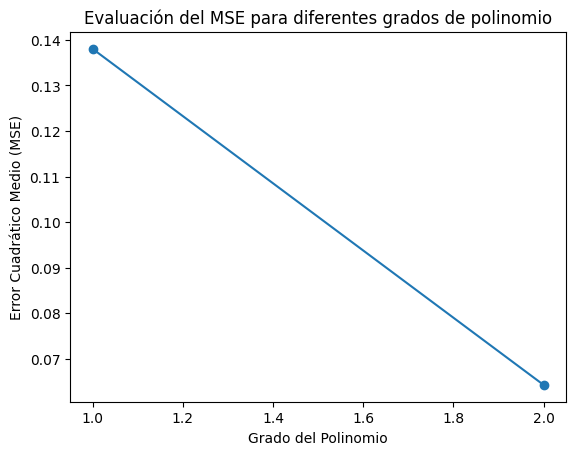

El grado óptimo del polinomio es: 2 con un MSE de: 0.06421065192630655


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Almacenar los MSE para cada grado
mse_scores = []

# Probar varios grados de polinomio
for degree in range(1, 3):  # Probar grados de 1 a 10
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    
    # Crear el modelo de regresión
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Realizar predicciones
    y_pred = model.predict(X_test)
    
    # Calcular el MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Graficar el MSE en función del grado
plt.plot(range(1, 3), mse_scores, marker='o')
plt.xlabel('Grado del Polinomio')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Evaluación del MSE para diferentes grados de polinomio')
plt.show()

# Imprimir el MSE más bajo y el grado correspondiente
optimal_degree = mse_scores.index(min(mse_scores)) + 1
print(f"El grado óptimo del polinomio es: {optimal_degree} con un MSE de: {min(mse_scores)}")
